# Neptune + PyTorch

## Logging and Visualizing debugging metrics with Neptune
**Global aggregated metrics**, such as overall loss and accuracy, provide a high-level view of a model's performance and help track progress toward the target task. These metrics are essential for assessing the model’s overall success and ensuring training is on the right path. However, **layer-wise metrics** offer deeper insights into how individual layers contribute to learning. By monitoring metrics like gradients and activations at each layer, we can identify specific issues (e.g., vanishing/exploding gradients) and optimize training for individual layers. This is crucial for deep networks, where different layers learn distinct types of features.

The main drawback of tracking layer-wise metrics is the **data overload** they can generate, especially with large/foundation models. Logging metrics for every layer can create significant data volume which researchers needs to log and monitor. However, with efficient tracking strategies and tools like Neptune, this challenge can be managed, allowing for detailed insights without overwhelming the training process.

### Introduction
See how Neptune Scale can be used for pre-training models like foundation models by tracking hundreds of metrics. This example is designed to be used as a code recipe for you to re-use sections with your own code to edit or adapt to your own model training needs. 

This guide will show you how to:
- Initialize the **Neptune Run** object and log configuration parameters
- Create a **class** to hook layer-wise metrics
- Log **aggregated metrics** such as loss and accuracy
- Log **debugging metrics** per layer during model training such as;
    * Activations
    * Gradients
    * Parameters (Weights and Biases)

## Before you start

  1. Create a Neptune Scale account. [Register &rarr;](https://neptune.ai/early-access)
  2. Create a Neptune project that you will use for tracking metadata. For instructions, see [Projects](https://docs-beta.neptune.ai/projects/) in the Neptune Scale docs.
  3. Install and configure Neptune Scale for logging metadata. For instructions, see [Get started](https://docs-beta.neptune.ai/setup) in the Neptune Scale docs.

### Install Dependencies and Import Libraries

In [ ]:
# Install dependencies
! pip install -q -U neptune_scale torch datasets

In [ ]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from collections import Counter
from datasets import load_dataset

from neptune_scale import Run

c:\Users\leo.breedt\miniconda3\envs\neptune_scale_py_312_base\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Initialize Parameters

In [2]:
# Initialize model, loss function, and optimizer

params = {
    "optimizer": "Adam",
    "batch_size": 8,
    "learning_rate": 0.01,
    "epochs": 5, 
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "input_features": 256,
    "embed_size": 1000,
    "hidden_size": 256, # hidden size for the LSTM
    "dropout_prob": 0.3,
    "num_lstm_layers": 3
}

## Download or use next token prediction dataset
The dataset used in this example is taken from [HuggingFace](https://huggingface.co/datasets/Na0s/Next_Token_Prediction_dataset). In this example, you can increase the size of the dataset to test the logging capabilities of Neptune, but note that increasing the dataset size will increase the time taken for the full dataset to download. The current setup only downloads the first parquet file from the Hugging Face public dataset. The validation dataset is also reduced to reduce the training loop execution time - you can increase the validation size by changing the `test_size` key-value pair in the `train_test_split()` method from HF. 

In [ ]:
# For the example, download a random subset of 10% of the original dataset
base_url = "https://huggingface.co/datasets/Na0s/Next_Token_Prediction_dataset/resolve/main/data/"
data_files = {"train": base_url + "train-00001-of-00067.parquet", # download only the first 10 files from the HF dataset
              "validation": base_url + "validation-00000-of-00001.parquet"} #doanload the complete validation dataset

data_subset = load_dataset("parquet", data_files = data_files, num_proc=4)
# validation_subset = load_dataset("parquet", data_files = {"validation": base_url + "validation-00000-of-00001.parquet"}, num_proc=4, split=["validation[:5%]"])
validation_subset = data_subset.get("validation").train_test_split(test_size=0.1)
print(f"Training samples: {data_subset['train'].num_rows} \nValidation samples: {validation_subset['test'].num_rows}")

Training samples: 81926 
Validation samples: 935


## Create DataLoader Objects
* To execute the models with PyTorch, we convert the training and validation datasets to tensors and then setup DataLoader for easier batching in our training loop.
* The model architecture requires the vocabulary size as an input and this we calcualte the max token from the dataset.

In [21]:
train_subset = data_subset["train"].with_format(type="torch", columns=["text", "input_ids", "labels"]) # HF provides methods to convert datatypes to tensors
validation_subset = validation_subset["test"].with_format(type="torch", columns=["text", "input_ids", "labels"]) # HF provides methods to convert datatypes to tensors

train_dataloader = DataLoader(train_subset, batch_size=params["batch_size"], shuffle=True)
val_dataloader = DataLoader(validation_subset, batch_size=params["batch_size"], shuffle=True)

# Determine the vocab size of the dataset
# Flatten the list of tokenized sentences into one long list of token IDs
vocab_size = max([token for sentence in data_subset["train"]["input_ids"] for token in sentence]) + 1
params["vocab_size"] = vocab_size
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 128257


## Importance of Logging Debugging Metrics

Tracking layer-wise metrics during training of foundation models is an important aspect of understanding and improving the performance of large-scale neural networks. Tracking layer-wise metrics is imporant to;
1) Understand the model behaviour at different depths
2) Diagnose training issues (vanishing/exploding gradients)
3) Model interpretability and debugging
4) Layer-specific regularization
5) Transfer learning insights

However, one drawback is the overwhelming amount of data generated that needs to be logged, tracked and analyzed. These models can have hundreds to thousands of layers making the data difficult to interpret. However, with Neptune this is not a problem. 

In this example, we will show you that it is possible to log and visualize layer-wise metrics such as activations, gradients as well as global metrics.

### Key metrics to capture from each layer:

| **Metric**                        | **Demonstrated in Notebook** | **What it Shows**                                                                                             | **How to Capture**                                             |
|-----------------------------------|--------------------------------------|--------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------|
| **Activations**                   | Yes                                  | Provides insight into how the model is processing data. Dead or exploding activations can indicate issues with training stability. | Use hooks to capture activations after each layer.            |
| **Gradients**                     | Yes                                  | Essential for diagnosing vanishing or exploding gradients. Small gradients may indicate vanishing gradients, while large ones can signal instability. | Use hooks to capture gradients during backpropagation.        |
| **Weights and Biases**            | Yes                                  | Tracks how the model’s parameters evolve during training. Large or small weights may indicate the need for better regularization or adjustments in learning rate. | Extract directly from the model’s parameters.                  |
| **Loss**               | No                                   | Identifies which parts of the network contribute more to the overall loss, aiding debugging and optimization. | Monitor outputs from each layer and compare with the target.   |
| **Learning Rate**       | No                                   | Helpful if using techniques like Layer-wise Learning Rate Decay (L2LRD). Tracking this can provide insight into the layer-specific learning rate. | Manually track based on optimizer settings.                    |
| **Output Norms**            | No                                   | The L2-norm of layer outputs can highlight issues like gradient explosion or vanishing gradients. | Compute the L2-norm for each layer’s output.                   |
| **Activation Distributions**      | No                                   | Helps diagnose saturation issues, especially with ReLU activations that may lead to dead neurons. | Visualize or compute statistical summaries using tools like matplotlib or seaborn. |
| **Feature Maps (for Convolutional Layers)** | No                                   | Offers insights into how convolutional layers detect specific patterns in the data. | Visualize feature maps after convolutional layers using libraries like matplotlib. |


### Define PyTorch Model Architecture and Helpers
We define a simple LLM model architecture using PyTorch. Since this is a text-based example, we use an embedding layer, a LSTM layer and a fully connected layer. This architecture can be adjusted to your needs and increased in size when testing the workflow. To increase the size of the LSTM layers, change the `num_layers` parameter in the parameters dictionary or to increase the number of fully connected layers, update the mode architecture itself.

This section also creates a `HookManager` class that allows us to capture the **activations** and **gradients** from each layer. You do not need to update this class as it will dynamically update according to the architecture of the model.

In [24]:
# Define the simple LLM model with LSTM
class SimpleLLM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
        super(SimpleLLM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers = num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)  # LSTM returns output and hidden/cell state tuple
        out = self.fc1(lstm_out) # Use the last output from the LSTM
        return out

# A class to manage hooks for activations and gradients
class HookManager:
    def __init__(self, model):
        self.model = model
        self.hooks = []
        self.activations = {}
        self.gradients = {}

    # Function to save activations
    def save_activation(self, name):
        def hook(module, input, output):
            self.activations[name] = output
        return hook

    # Function to save gradients (registering hooks for the model parameters)
    def save_gradient(self, name):
        def hook(module, grad_input, grad_output):
            self.gradients[name] = grad_output[0]
        return hook

    # Function to register hooks for activations and gradients
    def register_hooks(self):
        # Register forward hooks for activations
        for name, module in self.model.named_modules():
            self.hooks.append(module.register_forward_hook(self.save_activation(name)))

        # Register backward hooks for gradients
        for name, module in self.model.named_modules():
            if isinstance(module, (nn.LSTM, nn.Linear)): # You can add more layer types here
                self.hooks.append(module.register_full_backward_hook(self.save_gradient(name)))

    # Function to clear activations and gradients after use
    def clear(self):
        self.activations = {}
        self.gradients = {}

    # Function to get activations
    def get_activations(self):
        return self.activations

    # Function to get gradients
    def get_gradients(self):
        return self.gradients

# Function to evaluate the model after each epoch/step
def evaluate(model, val_dataloader, criterion, device, vocab_size):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # Disable gradient calculation for validation
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass for validation
            logits = model(input_ids)  # Shape: (batch_size, seq_len, vocab_size)
            
            # Calculate the loss
            loss = criterion(logits.view(-1, vocab_size), labels.view(-1))
            total_loss += loss.item()

    avg_val_loss = total_loss / len(val_dataloader)
    return avg_val_loss

## Setup Model Training
### Initialize Neptune Run object and Log Hyperparameters

In [ ]:
# Define Neptune parameters
from neptune_scale import Run
from uuid import uuid4

run = Run(
    project = "examples/pytorch-tutorial",
    run_id=f"pytorch-text-{uuid4()}"
    )

run.log_configs(
    {
        "config/learning_rate": params["learning_rate"],
        "config/optimizer": params["optimizer"],
        "config/batch_size": params["batch_size"],
        "config/epochs": params["epochs"],
        "config/num_lstm_layers" : params["num_lstm_layers"],
        "data/vocab_size": params["vocab_size"],
        "data/embed_size": params["embed_size"]
    }
)

run.add_tags(tags=[params["optimizer"]], group_tags=True)
run.add_tags(tags=["text", "LLM", "Simple"])

### Execute model training loop
In this loop, we configure the `HookManager` and register the hooks. In your training loop, you will need to use the `get_` methods to retrieve the stored values for the activations and gradients after the forward and backward passes are complete. Below, you can see a pseudo implementation:

```python
# Initialize model
model = your_ModelClass()
# Register hooks
hm = HookManager(model)
hm.register_hooks()

# Training loop
for epoch in range(3):
    
    # Forward pass, e.g. model.train()
    # Backward pass, e.g. loss.backward()
    
    activations = hm.get_activations()
    gradients = hm.get_gradients()

    # Log values (mean, std, etc.) to Neptune
```

Important: The `HookManager` class can be used in your own training script as it only accepts a model object as input.

In [ ]:
debug_metrics = {}

# Initialize model and optimizer
model = SimpleLLM(params["vocab_size"], params["embed_size"], params["hidden_size"], params["num_lstm_layers"])
optimizer = optim.Adam(model.parameters(), lr = params["learning_rate"])
criterion = nn.CrossEntropyLoss(ignore_index=-100) # Ignore the buffering index of -100 in the dataset

hook_manager = HookManager(model)
hook_manager.register_hooks()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
step_counter = 0

# Training loop
for epoch in range(params["epochs"]):
    total_loss = 0
    for batch in train_dataloader:
        model.train()
        step_counter += 1
        hook_manager.clear()

        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        logits = model(input_ids)
        
        # Compute the loss (ignore padding tokens by masking labels)
        loss = criterion(logits.view(-1, vocab_size), labels.view(-1))
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        
        total_loss += loss.item()
        print(f"Step {step_counter} / {len(train_dataloader)}, Loss: {loss.item()}")

        if step_counter % 5 == 0: # Do not need to log validation at every step, although we can
            val_loss = evaluate(model, val_dataloader, criterion, device, vocab_size)
            print(f"Step {step_counter}, Val_loss: {val_loss}")

            # Track activations
            activations = hook_manager.get_activations()
            for layer, activation in activations.items():
                if layer is not None:
                    debug_metrics[f"debug/activation/{layer}_mean"] = activation[0].mean().item()
                    debug_metrics[f"debug/activation/{layer}_std"] = activation[0].std().item()

            # Track gradients with hooks
            gradients = hook_manager.get_gradients()
            for layer, gradient in gradients.items():
               debug_metrics[f"debug/gradient/{layer}_mean"] = gradient.mean().item()
               print(f"Gradients for {layer}: {gradient.mean().item()}") # You can replace to use mean(), sum(), max() or min()
               # simplified_gradient = gradient.mean(dim=(0, 1))
               # print(f"Summed Gradient for {layer}: {simplified_gradient}")

            # Track gradients per layer at each epoch
            for layer, param in model.named_parameters():
                if param is not None:
                    debug_metrics[f"debug/parameters/{layer}_std"] = param.grad.std().item()
                    debug_metrics[f"debug/parameters/{layer}_mean"] = param.grad.mean().item()
                    debug_metrics[f"debug/parameters/{layer}_norm"] = param.grad.norm().item() # L2 norm (Euclidean norm) of the gradients

            # Output loss for this epoch
            run.log_metrics(
                data = {
                    "metrics/train/loss": loss.item(),
                    "metrics/validation/loss": val_loss,
                    "epoch/value": epoch,
                    **debug_metrics
                },
                step = step_counter
            )
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_dataloader)}")

# test_loss = evaluate_model(model, test_input, test_target, params["vocab_size"])
# print(f'Test Loss: {test_loss:.4f}')

# Close run to ensure all operations are processed
run.close()

## What next?

Navigate to the [Neptune Web App](https://scale.neptune.ai/) and visualize your runs in near real-time. See how each of the metrics evovle with each training step. Filter through each metric quickly to find the metrics you're most interested in. Use dashboards to create custom analysis of the layer-wise metrics like gradients and activations. Create dyanmic charts with advanced regex searching to add new layers to charts as you update and modify the model architecture.


### Advanced Regex searching
Navigate through hundreds of metrics super fast.

TODO - can we add gifs to show some cool UI things?

### Create dynamic charts
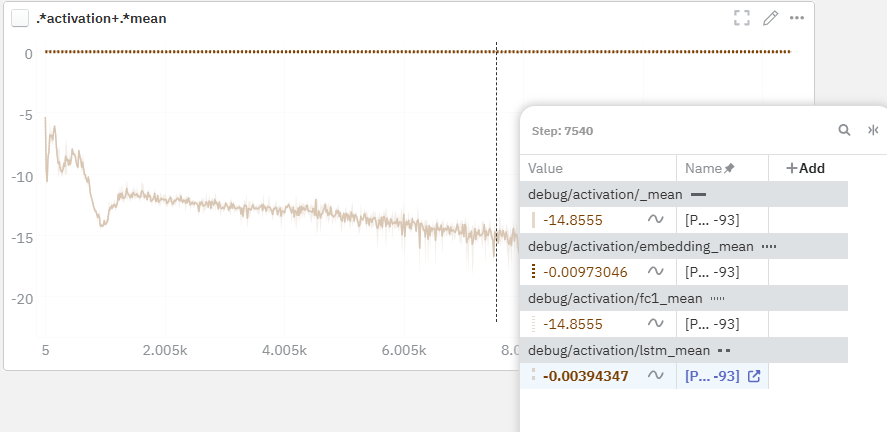